## Defining modules/packages to import

In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy

# importing package to recognize stop words i.e. the, and, an etc
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = spacy.lang.en.stop_words.STOP_WORDS

import datetime

import plotly.express as px

#nltk.download('punkt')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

stemmer = PorterStemmer()

In [2]:
# importing module to ignore the warnings
import warnings
warnings.simplefilter('ignore')

## Defining functions to be used

In [3]:
#### Now creating some functions to do text processing
# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """ 
    tweets cleaning by 
    1) lowering the case of the tweet, 
    2) removing unwanted symbols and replacing them with a whitespace, 
    3) split sentences into words according to whitespaces and then 
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string): 
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string (i.e. tweet in this case) and remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')
    pl.show('png')

## Search terms used to do tweet scraping

In [4]:
# basic list of terms to identify migrants
imm_basic = ["UK immigrant", "UK asylum seeker", "UK refugee", "UK borders", "UK illegal immigration", "UK undocumented migrant"]

###### Top ten modifiers of ‘immigrants’ or ‘migrants’, all publications, 2006-May 2015
immigration_modifiers = ["UK illegal", "UK EU", "UK European", "UK many", "UK new", "UK more", "UK African", "UK Jewish", "UK Polish", "UK Irish", "UK recent"]

immigrant = " immigrant"
# list modifier to inlcude singular and plural (immigrant vs immigrantS)
immigrant_mod = [s + immigrant + " OR " + s + immigrant + "s" for s in immigration_modifiers]

migrant = " migrant"
# list modifier to inlcude singular and plural (migrant vs migrantS)
migrant_mod = [s + migrant + " OR " + s + migrant + "s" for s in immigration_modifiers]

###### Top ten modifiers of ‘refugee(s)’, all publications, 2006-May 2015
refugee_modifiers = ["UK Syrian", "UK Palestinian", "UK Jewish", "UK many", "UK political", "UK Iraqi", "UK other", "UK more", "UK Afghan", "UK young"]
refugee = " refugee"
# list modifier to inlcude singular and plural (refugee vs refugeeS)
refugee_mod = [s + refugee + " OR " + s + refugee + "s" for s in refugee_modifiers]

# now concatenating words in lists to get one single string
imm_basic_concat = ' '.join(imm_basic)
immigrant_mod_concat = ' '.join(immigrant_mod)
migrant_mod_concat = ' '.join(migrant_mod)
refugee_mod_concat = ' '.join(refugee_mod)
search_concatenation = imm_basic_concat + ' ' + immigrant_mod_concat + ' ' + migrant_mod_concat  + ' ' + refugee_mod_concat
# now creating a string with unique occurrences of words from "search_concatenation"
search_concat_unique = removeDupWithoutOrder(search_concatenation).lower()

In [5]:
search_concat_unique

'uk immigrant asylum seeker refugee borders illegal immigration undocumented migrant or immigrants eu european many new more african jewish polish irish recent migrants syrian refugees palestinian political iraqi other afghan young'

## Now importing database to do analysis

In [6]:
# importing scraped database and putting it in df, taking only the columns below
df=pd.read_csv('../data/imm_df_2015_2016.csv')[['date','tweet','nlikes','nreplies','nretweets']]

In [7]:
df.head(5)

date                                              tweet  \
0  2015-10-01 01:10:14  195,227 signatures &amp; Climbing.PLEASE SHARE...   
1  2015-10-01 01:15:22  Related News: For Germans, worries swiftly fol...   
2  2015-10-01 01:35:33  Related News: For Germans, worries swiftly fol...   
3  2015-10-01 01:48:01  Christian and Muslim refugees should be housed...   
4  2015-10-01 01:48:24  UK Urges Globe to Support Turkey, Lebanon, Jor...   

   nlikes  nreplies  nretweets  
0       0         0          0  
1       0         0          0  
2       0         0          0  
3       0         0          0  
4       0         0          0

In [8]:
# taking the 'date' column (which is a string) and extracting date, times, breaking it down in months, years etc

df['INCDTTM'] =  pd.to_datetime(df['date'], infer_datetime_format=True)
df['Time'] = [datetime.datetime.time(d) for d in df['INCDTTM']] 
df['Date'] = [datetime.datetime.date(d) for d in df['INCDTTM']]
df['Year'] = [datetime.datetime.date(d).year for d in df['INCDTTM']] 
df['Month'] = [datetime.datetime.date(d).month for d in df['INCDTTM']] 
df['Day'] = [datetime.datetime.date(d).day for d in df['INCDTTM']] 
df['Hours'] = [datetime.datetime.time(d).hour for d in df['INCDTTM']] 
df['Minutes'] = [datetime.datetime.time(d).minute for d in df['INCDTTM']] 
df['Seconds'] = [datetime.datetime.time(d).second for d in df['INCDTTM']]
df = df.drop(columns = ['date','INCDTTM'])
df.head()

tweet  nlikes  nreplies  \
0  195,227 signatures &amp; Climbing.PLEASE SHARE...       0         0   
1  Related News: For Germans, worries swiftly fol...       0         0   
2  Related News: For Germans, worries swiftly fol...       0         0   
3  Christian and Muslim refugees should be housed...       0         0   
4  UK Urges Globe to Support Turkey, Lebanon, Jor...       0         0   

   nretweets      Time        Date  Year  Month  Day  Hours  Minutes  Seconds  
0          0  01:10:14  2015-10-01  2015     10    1      1       10       14  
1          0  01:15:22  2015-10-01  2015     10    1      1       15       22  
2          0  01:35:33  2015-10-01  2015     10    1      1       35       33  
3          0  01:48:01  2015-10-01  2015     10    1      1       48        1  
4          0  01:48:24  2015-10-01  2015     10    1      1       48       24

In [9]:
# removing useless content (hashtags, mentions)
df['tweet']=df['tweet'].apply(lambda x: remove_content(x))

In [10]:
# Several functions applied here: processing the *tweet* to remove punctuation, hashtags, mentions
# then removing the search terms used to do the tweets scraping and re-process the *text* 

df['cleaned_tweets']=df['tweet'].apply(lambda x: process_tweet(x))

#this next row drops from the scraped tweets the same keywords that were used to perform the search.
#if these words are excluded, the sentiment analysis performed with text blob looks at the whole tweet 
#and can spit out a different sentiment wrt if leaving the search terms in. Perhaps worth test it out a bit
#and look at TextBlob with naivebayes too.

#df['cleaned_tweets']=df['cleaned_tweets'].apply(lambda x: remove_search(x, search_concat_unique))

df['cleaned_tweets']=df['cleaned_tweets'].apply(lambda x: process_text(x))

In [11]:
df.head()

tweet  nlikes  nreplies  \
0  195,227 signatures &amp; Climbing.PLEASE SHARE...       0         0   
1  Related News: For Germans, worries swiftly fol...       0         0   
2  Related News: For Germans, worries swiftly fol...       0         0   
3  Christian and Muslim refugees should be housed...       0         0   
4  UK Urges Globe to Support Turkey, Lebanon, Jor...       0         0   

   nretweets      Time        Date  Year  Month  Day  Hours  Minutes  Seconds  \
0          0  01:10:14  2015-10-01  2015     10    1      1       10       14   
1          0  01:15:22  2015-10-01  2015     10    1      1       15       22   
2          0  01:35:33  2015-10-01  2015     10    1      1       35       33   
3          0  01:48:01  2015-10-01  2015     10    1      1       48        1   
4          0  01:48:24  2015-10-01  2015     10    1      1       48       24   

                                      cleaned_tweets  
0  signature climbing share sign debate oct stop ...  
1  related news german worry swiftly follow refug...  
2  related news german worry swiftly follow refug...  
3  christian muslim refugee housed separately say...  
4  uk urge globe support turkey lebanon jordan ac...

In [12]:
# taking the cleaning tweets and dividing them using the space - cleaned tweets contain tweets that are stemmed and cleaned
tweet_list = df['cleaned_tweets'].tolist()
all_words=' '.join(tweet_list).split()

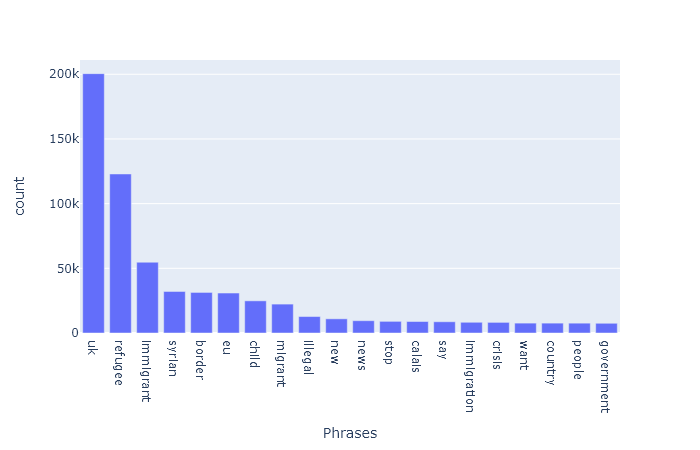

In [13]:
plot_topn(tweet_list, ngram_range=(1,1))

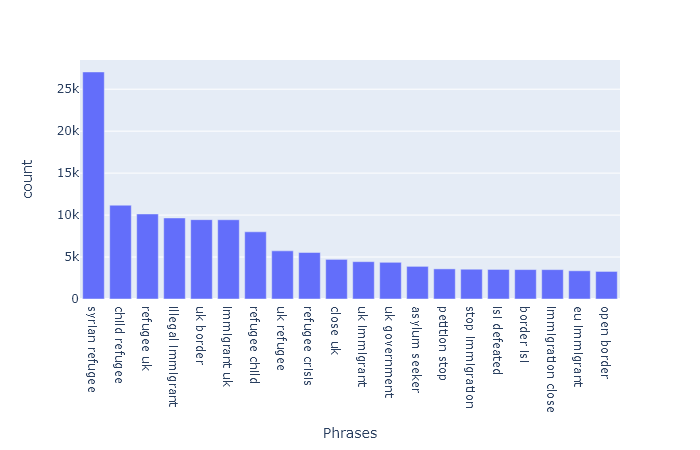

In [14]:
plot_topn(tweet_list, ngram_range=(2,2))

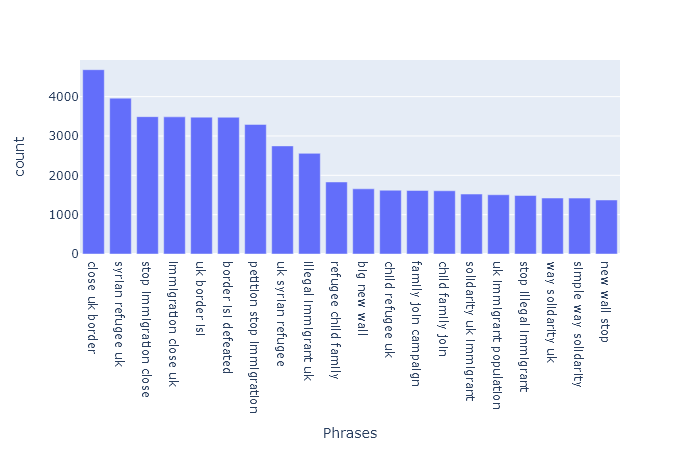

In [15]:
plot_topn(tweet_list, ngram_range=(3,3))

## Wordcloud of most used words

In [16]:
from wordcloud import WordCloud, STOPWORDS
temp=' '.join(df['cleaned_tweets'].tolist())
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(temp)

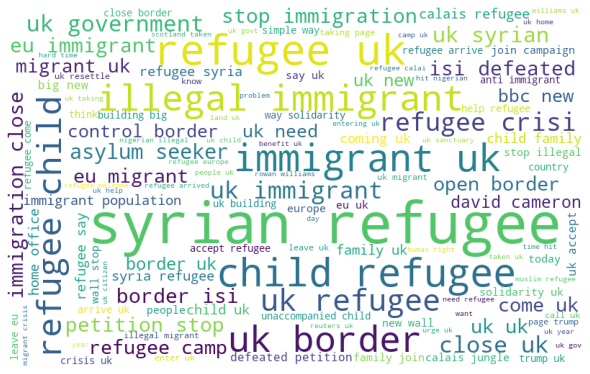

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show('png')

## Sentiment analysis

In [18]:
from textblob import TextBlob 

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'    

In [19]:
df.head()

tweet  nlikes  nreplies  \
0  195,227 signatures &amp; Climbing.PLEASE SHARE...       0         0   
1  Related News: For Germans, worries swiftly fol...       0         0   
2  Related News: For Germans, worries swiftly fol...       0         0   
3  Christian and Muslim refugees should be housed...       0         0   
4  UK Urges Globe to Support Turkey, Lebanon, Jor...       0         0   

   nretweets      Time        Date  Year  Month  Day  Hours  Minutes  Seconds  \
0          0  01:10:14  2015-10-01  2015     10    1      1       10       14   
1          0  01:15:22  2015-10-01  2015     10    1      1       15       22   
2          0  01:35:33  2015-10-01  2015     10    1      1       35       33   
3          0  01:48:01  2015-10-01  2015     10    1      1       48        1   
4          0  01:48:24  2015-10-01  2015     10    1      1       48       24   

                                      cleaned_tweets  
0  signature climbing share sign debate oct stop ...  
1  related news german worry swiftly follow refug...  
2  related news german worry swiftly follow refug...  
3  christian muslim refugee housed separately say...  
4  uk urge globe support turkey lebanon jordan ac...

In [20]:
df['sentiment']=df['cleaned_tweets'].apply(lambda x: get_tweet_sentiment(x))

In [21]:
df.head()

tweet  nlikes  nreplies  \
0  195,227 signatures &amp; Climbing.PLEASE SHARE...       0         0   
1  Related News: For Germans, worries swiftly fol...       0         0   
2  Related News: For Germans, worries swiftly fol...       0         0   
3  Christian and Muslim refugees should be housed...       0         0   
4  UK Urges Globe to Support Turkey, Lebanon, Jor...       0         0   

   nretweets      Time        Date  Year  Month  Day  Hours  Minutes  Seconds  \
0          0  01:10:14  2015-10-01  2015     10    1      1       10       14   
1          0  01:15:22  2015-10-01  2015     10    1      1       15       22   
2          0  01:35:33  2015-10-01  2015     10    1      1       35       33   
3          0  01:48:01  2015-10-01  2015     10    1      1       48        1   
4          0  01:48:24  2015-10-01  2015     10    1      1       48       24   

                                      cleaned_tweets sentiment  
0  signature climbing share sign debate oct stop ...   neutral  
1  related news german worry swiftly follow refug...  positive  
2  related news german worry swiftly follow refug...  positive  
3  christian muslim refugee housed separately say...   neutral  
4  uk urge globe support turkey lebanon jordan ac...   neutral

In [22]:
df.sentiment.value_counts()

neutral     125007
positive     56639
negative     44089
Name: sentiment, dtype: int64

In [23]:
df['Positive']= df['sentiment'].apply(lambda x: 1 if (x=="positive")  else 0)
df['Negative']= df['sentiment'].apply(lambda x: 1 if (x=="negative")  else 0)
df['Neutral']= df['sentiment'].apply(lambda x: 1 if (x=="neutral")  else 0)

df.head()

tweet  nlikes  nreplies  \
0  195,227 signatures &amp; Climbing.PLEASE SHARE...       0         0   
1  Related News: For Germans, worries swiftly fol...       0         0   
2  Related News: For Germans, worries swiftly fol...       0         0   
3  Christian and Muslim refugees should be housed...       0         0   
4  UK Urges Globe to Support Turkey, Lebanon, Jor...       0         0   

   nretweets      Time        Date  Year  Month  Day  Hours  Minutes  Seconds  \
0          0  01:10:14  2015-10-01  2015     10    1      1       10       14   
1          0  01:15:22  2015-10-01  2015     10    1      1       15       22   
2          0  01:35:33  2015-10-01  2015     10    1      1       35       33   
3          0  01:48:01  2015-10-01  2015     10    1      1       48        1   
4          0  01:48:24  2015-10-01  2015     10    1      1       48       24   

                                      cleaned_tweets sentiment  Positive  \
0  signature climbing share sign debate oct stop ...   neutral         0   
1  related news german worry swiftly follow refug...  positive         1   
2  related news german worry swiftly follow refug...  positive         1   
3  christian muslim refugee housed separately say...   neutral         0   
4  uk urge globe support turkey lebanon jordan ac...   neutral         0   

   Negative  Neutral  
0         0        1  
1         0        0  
2         0        0  
3         0        1  
4         0        1

In [24]:
df_timeline = df.groupby(df.Date).sum().reset_index()
df_timeline['Total'] = df_timeline.Positive + df_timeline.Negative + df_timeline.Neutral
df_timeline

Date  nlikes  nreplies  nretweets     Year  Month    Day  Hours  \
0    2015-10-01     221        76        365  1011530   5020    502   6563   
1    2015-10-02    1124       173       1527  1269450   6300   1260   9005   
2    2015-10-03     582        98       1063  1265420   6280   1884   6223   
3    2015-10-04     229        78        392   701220   3480   1392   4764   
4    2015-10-05     450       141        707  1055860   5240   2620   6627   
..          ...     ...       ...        ...      ...    ...    ...    ...   
361  2016-09-26     899       555        807  1072512   4788  13832   6844   
362  2016-09-27     940       168        901   822528   3672  11016   4898   
363  2016-09-28     579       120       1191   856800   3825  11900   5483   
364  2016-09-29     810       112        644   683424   3051   9831   5027   
365  2016-09-30     388       111        448   818496   3654  12180   5055   

     Minutes  Seconds  Positive  Negative  Neutral  Total  
0      14160    15238       125        48      329    502  
1      17054    18594       244        55      331    630  
2      18730    17759       334        43      251    628  
3      10314     9425        97        46      205    348  
4      15245    15815       121        56      347    524  
..       ...      ...       ...       ...      ...    ...  
361    14656    15457       119       117      296    532  
362    11380    11390        93        75      240    408  
363    12390    12522       164        82      179    425  
364     9468     9289       130        59      150    339  
365    10825    11032       132        56      218    406  

[366 rows x 14 columns]

In [25]:
import numpy as np
from datetime import datetime, timedelta

t = np.arange(df_timeline.Date[0], df_timeline.Date[365], timedelta(days=7)).astype(datetime)

In [26]:
#plt.figure(figsize=(20,5))
#plt.bar(df_timeline.Date, (df_timeline['Positive']/df_timeline['Total']));
#plt.bar(df_timeline.Date, (df_timeline['Negative']/df_timeline['Total']), bottom = (df_timeline['Positive']/df_timeline['Total']));
#plt.legend(['Positive', 'Negative']);
#plt.xticks(t, rotation='vertical');
#plt.ylabel('Number of positive and negative tweets');
#plt.xlabel('Date');

In [27]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
fig.add_bar(x=df_timeline.Date, y=100*df_timeline.Negative/(df_timeline.Total), name="% Negative")
fig.add_bar(x=df_timeline.Date, y=100*df_timeline.Positive/(df_timeline.Total), name="% Positive")
fig.add_bar(x=df_timeline.Date, y=100*df_timeline.Neutral/df_timeline.Total, name="% Neutral")
fig.add_trace(go.Scatter(x=[df_timeline.Date[0], df_timeline.Date[365]],y=[50,50],name="50% threshold"))
fig.update_layout(barmode="relative")
fig.update_layout(showlegend=True,title="Tweets split by sentiment: % positive, % negative and % neutral",
                 yaxis_title="% of total tweets", xaxis_title="Time")
fig.show()

### Some further analyses on percentages of positive/negative/neutral tweets and saving them locally

In [28]:
df_new = df_timeline[['Date', 'Negative','Positive','Neutral','Total']].copy()

In [29]:
df_new['Percentage_neg'] = 100*(df_new.Negative/df_new.Total)
df_new['Percentage_pos'] = 100*(df_new.Positive/df_new.Total)
df_new['Percentage_neutr'] = 100*(df_new.Neutral/df_new.Total)
df_new.head()

Date  Negative  Positive  Neutral  Total  Percentage_neg  \
0  2015-10-01        48       125      329    502        9.561753   
1  2015-10-02        55       244      331    630        8.730159   
2  2015-10-03        43       334      251    628        6.847134   
3  2015-10-04        46        97      205    348       13.218391   
4  2015-10-05        56       121      347    524       10.687023   

   Percentage_pos  Percentage_neutr  
0       24.900398         65.537849  
1       38.730159         52.539683  
2       53.184713         39.968153  
3       27.873563         58.908046  
4       23.091603         66.221374

In [30]:
df_new.shape

(366, 8)

In [31]:
#df_new.to_csv('../data/lgbtq_2019_2020_postprocessed.csv', index=False)

### Now we turn our attention to the reactions and engagements - by categories: likes, replies, retweets. What is making more 'noise'? Negative or positive tweets?

In [32]:
reactions_vert = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 'Negative_nlikes', 'Negative_nreplies', 'Negative_nretweets', 'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets', 'Total_nlikes', 'Total_nreplies', 'Total_nretweets'])

In [33]:
reactions_vert.Date = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().Date
reactions_vert.Positive_nlikes = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().nlikes
reactions_vert.Positive_nreplies = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().nreplies
reactions_vert.Positive_nretweets = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().nretweets

reactions_vert.Negative_nlikes = df.loc[df['Negative'] == 1].groupby(df.Date).sum().reset_index().nlikes
reactions_vert.Negative_nreplies = df.loc[df['Negative'] == 1].groupby(df.Date).sum().reset_index().nreplies
reactions_vert.Negative_nretweets = df.loc[df['Negative'] == 1].groupby(df.Date).sum().reset_index().nretweets

reactions_vert.Neutral_nlikes = df.loc[df['Neutral'] == 1].groupby(df.Date).sum().reset_index().nlikes
reactions_vert.Neutral_nreplies = df.loc[df['Neutral'] == 1].groupby(df.Date).sum().reset_index().nreplies
reactions_vert.Neutral_nretweets = df.loc[df['Neutral'] == 1].groupby(df.Date).sum().reset_index().nretweets

#cumulative total of likes, replies and retweets per day

reactions_vert.Total_nlikes = reactions_vert.Positive_nlikes + reactions_vert.Negative_nlikes + reactions_vert.Neutral_nlikes
reactions_vert.Total_nreplies = reactions_vert.Positive_nreplies + reactions_vert.Negative_nreplies + reactions_vert.Neutral_nreplies
reactions_vert.Total_nretweets = reactions_vert.Positive_nretweets + reactions_vert.Negative_nretweets + reactions_vert.Neutral_nretweets

In [34]:
reactions_vert.head()

Date  Positive_nlikes  Positive_nreplies  Positive_nretweets  \
0  2015-10-01               85                 20                 137   
1  2015-10-02              977                121                1315   
2  2015-10-03              309                 41                 448   
3  2015-10-04               97                 31                 147   
4  2015-10-05              123                 21                 177   

   Negative_nlikes  Negative_nreplies  Negative_nretweets  Neutral_nlikes  \
0               22                  7                  22             114   
1               22                 11                  19             125   
2               61                 19                 250             212   
3               39                 14                  80              93   
4               16                  8                  23             311   

   Neutral_nreplies  Neutral_nretweets  Total_nlikes  Total_nreplies  \
0                49                206           221              76   
1                41                193          1124             173   
2                38                365           582              98   
3                33                165           229              78   
4               112                507           450             141   

   Total_nretweets  
0              365  
1             1527  
2             1063  
3              392  
4              707

In [35]:
reactions_vert.shape

(366, 13)

In [36]:
reactions_vert.to_csv('../data/imm_2015_2016_reactions_vert.csv', index=False)

In [37]:
reactions_perc_v = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 'Negative_nlikes', 'Negative_nreplies', 'Negative_nretweets', 'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets'])

reactions_perc_v.Date = reactions_vert.Date

# Now defining percentages of each reaction (like or reply or retweet) wrt to their total across sentiment. 
# By doing so we're calculating how each reaction is split by **sentiment** 

reactions_perc_v.Positive_nlikes = 100*reactions_vert.Positive_nlikes/reactions_vert.Total_nlikes
reactions_perc_v.Positive_nreplies = 100*reactions_vert.Positive_nreplies/reactions_vert.Total_nreplies
reactions_perc_v.Positive_nretweets = 100*reactions_vert.Positive_nretweets/reactions_vert.Total_nretweets

reactions_perc_v.Negative_nlikes = 100*reactions_vert.Negative_nlikes/reactions_vert.Total_nlikes
reactions_perc_v.Negative_nreplies = 100*reactions_vert.Negative_nreplies/reactions_vert.Total_nreplies
reactions_perc_v.Negative_nretweets = 100*reactions_vert.Negative_nretweets/reactions_vert.Total_nretweets

reactions_perc_v.Neutral_nlikes = 100*reactions_vert.Neutral_nlikes/reactions_vert.Total_nlikes
reactions_perc_v.Neutral_nreplies = 100*reactions_vert.Neutral_nreplies/reactions_vert.Total_nreplies
reactions_perc_v.Neutral_nretweets = 100*reactions_vert.Neutral_nretweets/reactions_vert.Total_nretweets

reactions_perc_v['Positive tweets'] = 100*df_timeline.Positive/df_timeline.Total
reactions_perc_v['Negative tweets'] = 100*df_timeline.Negative/df_timeline.Total
reactions_perc_v['Neutral tweets'] = 100*df_timeline.Neutral/df_timeline.Total

reactions_perc_v.head()

Date  Positive_nlikes  Positive_nreplies  Positive_nretweets  \
0  2015-10-01        38.461538          26.315789           37.534247   
1  2015-10-02        86.921708          69.942197           86.116568   
2  2015-10-03        53.092784          41.836735           42.144873   
3  2015-10-04        42.358079          39.743590           37.500000   
4  2015-10-05        27.333333          14.893617           25.035361   

   Negative_nlikes  Negative_nreplies  Negative_nretweets  Neutral_nlikes  \
0         9.954751           9.210526            6.027397       51.583710   
1         1.957295           6.358382            1.244270       11.120996   
2        10.481100          19.387755           23.518344       36.426117   
3        17.030568          17.948718           20.408163       40.611354   
4         3.555556           5.673759            3.253182       69.111111   

   Neutral_nreplies  Neutral_nretweets  Positive tweets  Negative tweets  \
0         64.473684          56.438356        24.900398         9.561753   
1         23.699422          12.639162        38.730159         8.730159   
2         38.775510          34.336783        53.184713         6.847134   
3         42.307692          42.091837        27.873563        13.218391   
4         79.432624          71.711457        23.091603        10.687023   

   Neutral tweets  
0       65.537849  
1       52.539683  
2       39.968153  
3       58.908046  
4       66.221374

In [38]:
reactions_perc_v.to_csv('../data/imm_2015_2016_reactions_perc_v.csv', index=False)

### Plots showing for each type of reactions, what's the split by sentiment - first by % then by absolute numbers

In [39]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Positive_nlikes, name="% Positive", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Negative_nlikes, name="% Negative", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Neutral_nlikes, name="% Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Likes' split by sentiment",
                 yaxis_title="% of likes", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Positive_nreplies, name="% Positive", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Negative_nreplies, name="% Negative", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Neutral_nreplies, name="% Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Replies' split by sentiment",
                 yaxis_title="% of replies", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Positive_nretweets, name="% Positive", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Negative_nretweets, name="% Negative", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Neutral_nretweets, name="% Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Retweets' split by sentiment",
                 yaxis_title="% of retweets", xaxis_title="Time")
fig.show()


In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Positive_nlikes, name="Positive", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Negative_nlikes, name="Negative", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Neutral_nlikes, name="Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Likes' split by sentiment",
                 yaxis_title="Number of likes", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Positive_nreplies, name="Positive", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Negative_nreplies, name="Negative", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Neutral_nreplies, name="Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Replies' split by sentiment",
                 yaxis_title="Number of replies", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Positive_nretweets, name="Positive", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Negative_nretweets, name="Negative", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Neutral_nretweets, name="Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Retweets' split by sentiment",
                 yaxis_title="Number of retweets", xaxis_title="Time")
fig.show()


In [41]:
# Now we create a new dataframe to illustrate how each sentiment is split by reaction

reactions_hor = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 'Negative_nlikes', 'Negative_nreplies', 
                                  'Negative_nretweets', 'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets', 
                                  'Total_Positive', 'Total_Negative', 'Total_Neutral'])

reactions_hor.Date = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().Date
reactions_hor.Positive_nlikes = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().nlikes
reactions_hor.Positive_nreplies = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().nreplies
reactions_hor.Positive_nretweets = df.loc[df['Positive'] == 1].groupby(df.Date).sum().reset_index().nretweets

reactions_hor.Negative_nlikes = df.loc[df['Negative'] == 1].groupby(df.Date).sum().reset_index().nlikes
reactions_hor.Negative_nreplies = df.loc[df['Negative'] == 1].groupby(df.Date).sum().reset_index().nreplies
reactions_hor.Negative_nretweets = df.loc[df['Negative'] == 1].groupby(df.Date).sum().reset_index().nretweets

reactions_hor.Neutral_nlikes = df.loc[df['Neutral'] == 1].groupby(df.Date).sum().reset_index().nlikes
reactions_hor.Neutral_nreplies = df.loc[df['Neutral'] == 1].groupby(df.Date).sum().reset_index().nreplies
reactions_hor.Neutral_nretweets = df.loc[df['Neutral'] == 1].groupby(df.Date).sum().reset_index().nretweets

#cumulative total of (likes+replies+retweets) per day by sentiment

reactions_hor.Total_Positive = reactions_hor.Positive_nlikes + reactions_hor.Positive_nreplies + reactions_hor.Positive_nretweets
reactions_hor.Total_Negative = reactions_hor.Negative_nlikes + reactions_hor.Negative_nreplies + reactions_hor.Negative_nretweets
reactions_hor.Total_Neutral = reactions_hor.Neutral_nlikes + reactions_hor.Neutral_nreplies + reactions_hor.Neutral_nretweets

reactions_hor.head()

Date  Positive_nlikes  Positive_nreplies  Positive_nretweets  \
0  2015-10-01               85                 20                 137   
1  2015-10-02              977                121                1315   
2  2015-10-03              309                 41                 448   
3  2015-10-04               97                 31                 147   
4  2015-10-05              123                 21                 177   

   Negative_nlikes  Negative_nreplies  Negative_nretweets  Neutral_nlikes  \
0               22                  7                  22             114   
1               22                 11                  19             125   
2               61                 19                 250             212   
3               39                 14                  80              93   
4               16                  8                  23             311   

   Neutral_nreplies  Neutral_nretweets  Total_Positive  Total_Negative  \
0                49                206             242              51   
1                41                193            2413              52   
2                38                365             798             330   
3                33                165             275             133   
4               112                507             321              47   

   Total_Neutral  
0            369  
1            359  
2            615  
3            291  
4            930

In [42]:
reactions_hor.to_csv('../data/imm_2015_2016_reactions_hor.csv', index=False)

In [43]:
reactions_perc_h = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 
                                         'Negative_nlikes', 'Negative_nreplies', 'Negative_nretweets', 
                                         'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets'])

reactions_perc_h.Date = reactions_hor.Date

# Now defining percentages of each reaction (like or reply or retweet) wrt to their total across sentiment. 
# By doing so we're calculating how each reaction is split by **sentiment** 

reactions_perc_h.Positive_nlikes = 100*reactions_hor.Positive_nlikes/reactions_hor.Total_Positive
reactions_perc_h.Positive_nreplies = 100*reactions_hor.Positive_nreplies/reactions_hor.Total_Positive
reactions_perc_h.Positive_nretweets = 100*reactions_hor.Positive_nretweets/reactions_hor.Total_Positive

reactions_perc_h.Negative_nlikes = 100*reactions_hor.Negative_nlikes/reactions_hor.Total_Negative
reactions_perc_h.Negative_nreplies = 100*reactions_hor.Negative_nreplies/reactions_hor.Total_Negative
reactions_perc_h.Negative_nretweets = 100*reactions_hor.Negative_nretweets/reactions_hor.Total_Negative

reactions_perc_h.Neutral_nlikes = 100*reactions_hor.Neutral_nlikes/reactions_hor.Total_Neutral
reactions_perc_h.Neutral_nreplies = 100*reactions_hor.Neutral_nreplies/reactions_hor.Total_Neutral
reactions_perc_h.Neutral_nretweets = 100*reactions_hor.Neutral_nretweets/reactions_hor.Total_Neutral

reactions_perc_h['Positive tweets'] = 100*df_timeline.Positive/df_timeline.Total
reactions_perc_h['Negative tweets'] = 100*df_timeline.Negative/df_timeline.Total
reactions_perc_h['Neutral tweets'] = 100*df_timeline.Neutral/df_timeline.Total

reactions_perc_h.head()

Date  Positive_nlikes  Positive_nreplies  Positive_nretweets  \
0  2015-10-01        35.123967           8.264463           56.611570   
1  2015-10-02        40.489018           5.014505           54.496477   
2  2015-10-03        38.721805           5.137845           56.140351   
3  2015-10-04        35.272727          11.272727           53.454545   
4  2015-10-05        38.317757           6.542056           55.140187   

   Negative_nlikes  Negative_nreplies  Negative_nretweets  Neutral_nlikes  \
0        43.137255          13.725490           43.137255       30.894309   
1        42.307692          21.153846           36.538462       34.818942   
2        18.484848           5.757576           75.757576       34.471545   
3        29.323308          10.526316           60.150376       31.958763   
4        34.042553          17.021277           48.936170       33.440860   

   Neutral_nreplies  Neutral_nretweets  Positive tweets  Negative tweets  \
0         13.279133          55.826558        24.900398         9.561753   
1         11.420613          53.760446        38.730159         8.730159   
2          6.178862          59.349593        53.184713         6.847134   
3         11.340206          56.701031        27.873563        13.218391   
4         12.043011          54.516129        23.091603        10.687023   

   Neutral tweets  
0       65.537849  
1       52.539683  
2       39.968153  
3       58.908046  
4       66.221374

In [44]:
reactions_perc_h.to_csv('../data/imm_2015_2016_reactions_perc_h.csv', index=False)

### Plots showing for each type of sentiment, what's the split by reaction type - first by % then by absolute numbers

In [45]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Positive_nlikes, name="% Likes", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Positive_nreplies, name="% Replies", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Positive_nretweets, name="% Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for positive tweets",
                 yaxis_title="% of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Negative_nlikes, name="% Likes", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Negative_nreplies, name="% Replies", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Negative_nretweets, name="% Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for negative tweets",
                 yaxis_title="% of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Neutral_nlikes, name="% Likes", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Neutral_nreplies, name="% Replies", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Neutral_nretweets, name="% Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for neutral tweets",
                 yaxis_title="% of reactions", xaxis_title="Time")
fig.show()


In [46]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Positive_nlikes, name="Likes", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Positive_nreplies, name="Replies", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Positive_nretweets, name="Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for positive tweets",
                 yaxis_title="Number of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Negative_nlikes, name="Likes", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Negative_nreplies, name="Replies", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Negative_nretweets, name="Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for negative tweets",
                 yaxis_title="Number of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Neutral_nlikes, name="Likes", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Neutral_nreplies, name="Replies", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Neutral_nretweets, name="Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for neutral tweets",
                 yaxis_title="Number of reactions", xaxis_title="Time")
fig.show()
